In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster


#### Read in Metro Parks Boundaries 


In [2]:
parks = gpd.read_file('../data/Metro Parks Boundaries (GIS).geojson')
parks.head(3)

,acres,name,year_estab,common_nam,status,address,lon,lat,descriptio,geometry
0,69.86,Harpeth River Park,1988,Harpeth River,PARK,7820 Coley Davis Rd,-86.9592214,36.07738249,Harpeth River State Park has much historical a...,"MULTIPOLYGON (((-86.95547 36.07930, -86.95578 ..."
1,9.88,Harpeth Knoll Park,1972,Harpeth Knoll,PARK,708 Goodpasture Terrace,-86.93815537,36.05942777,"Huge grassy field with playground, and shade s...","MULTIPOLYGON (((-86.93860 36.06077, -86.93742 ..."
2,17.14,Bellevue Park,1982,Red Caboose,PARK,656 Colice Jeanne Rd,-86.93354496,36.07159731,"Bellevue Park, known as Red Caboose Park, is p...","MULTIPOLYGON (((-86.93207 36.06954, -86.93283 ..."


#### needs to be cleaned
    rename columns
    drop unwanted columns
   

In [3]:
#drop columns
parks = parks.drop(columns = ['year_estab','common_nam','address','lon','lat','descriptio'])
#school_and_gender_counts = school_and_gender_counts.rename(columns = {'level': 'type', 'name': 'school'})
parks = parks.rename(columns = {'status':'park_type'})
parks.head()


,acres,name,park_type,geometry
0,69.86,Harpeth River Park,PARK,"MULTIPOLYGON (((-86.95547 36.07930, -86.95578 ..."
1,9.88,Harpeth Knoll Park,PARK,"MULTIPOLYGON (((-86.93860 36.06077, -86.93742 ..."
2,17.14,Bellevue Park,PARK,"MULTIPOLYGON (((-86.93207 36.06954, -86.93283 ..."
3,809.59,Bells Bend Park,PARK,"MULTIPOLYGON (((-86.93987 36.16093, -86.93495 ..."
4,2168.792,Alvin G. Beaman Park,PARK,"MULTIPOLYGON (((-86.90367 36.27352, -86.90364 ..."


#### Change the crs

In [4]:
parks.crs = "EPSG:4326"
print(parks.crs)

EPSG:4326


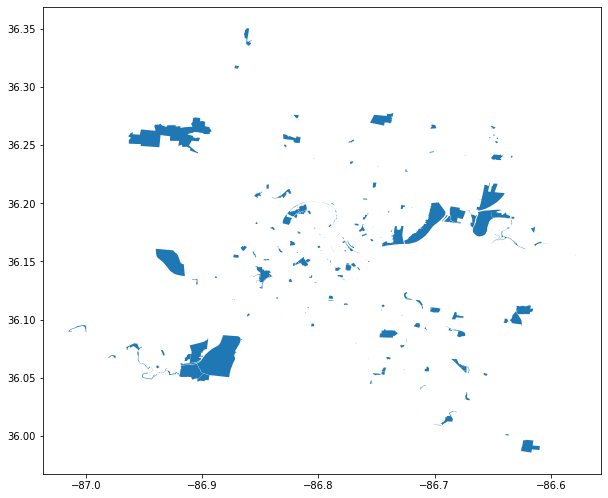

In [5]:
# couldn't get the name column to work for this

parks.plot(figsize = (10,10))


#### Load bus stop data
#### Create geometry column

In [6]:
bus_stops = pd.read_csv('../data/busstops_cleaned.csv')
bus_stops.shape

(2524, 5)

In [7]:
bus_stops['geometry'] = bus_stops.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)
bus_stops.head(3)

,stop,route,location,lat,lng,geometry
0,GREEN LN & WHITES CREEK PIKE WB,GOLDEN VALLEY,"(36.236249, -86.816722)",36.236249,-86.816722,POINT (-86.816722 36.236249)
1,_ 9TH AVE S & EDGEHILL AVE SB,8TH AVENUE SOUTH,"(36.142642, -86.780897)",36.142642,-86.780897,POINT (-86.780897 36.142642)
2,DONELSON/DELL STATION OUTBOUND,MURFREESBORO PIKE,"(36.105615, -86.672004)",36.105615,-86.672004,POINT (-86.672004 36.105615)


#### Build GeoDataFrame

In [8]:
bus_geodf = gpd.GeoDataFrame(bus_stops,
                             crs = "EPSG:4326",  # if you want to switch crs here
                             geometry = bus_stops['geometry'])
# if you want to drop lat and lng
# bus_geodf = bus_geodf.drop(columns=['lat','lng']) 

In [9]:
#bus_geodf.crs = "EPSG:4326"
print(bus_geodf.crs)

EPSG:4326


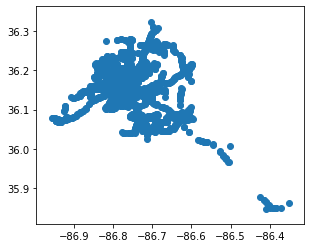

In [10]:
bus_geodf.plot()

#### Join that spatial y'all...
#### ...let's do a contains join for now


In [11]:
stops_and_parks = gpd.sjoin(bus_geodf, parks, op = 'within')
stops_and_parks.head(10)

,stop,route,location,lat,lng,geometry,index_right,acres,name,park_type
330,NASHVILLE ZOO STATION OUTBOUND,NOLENSVILLE PK BRT LITE,"(36.089633, -86.733396)",36.089633,-86.733396,POINT (-86.73340 36.08963),77,196.59,Grassmere / Nashville Zoo,PARK
501,LISCHEY AVE & EDWIN ST NB,MERIDIAN,"(36.204161, -86.761283)",36.204161,-86.761283,POINT (-86.76128 36.20416),72,6.81,Tom Joy Park,PARK
1193,EDMONDSON PIKE & NOLENSVILLE PIKE W,GRASSMERE-EDMONDSON CONNECTOR,"(36.076501, -86.727201)",36.076501,-86.727201,POINT (-86.72720 36.07650),62,13.53,Wentworth-Caldwell Park,PARK
1350,MUSIC CITY STAR RIVERFRONT STATION,LEBANON PIKE,"(36.161803, -86.773763)",36.161803,-86.773763,POINT (-86.77376 36.16180),59,5.29,Riverfront Park,PARK
2128,S GALLATIN PIKE & BROADMOOR DR NB,GALLATIN PIKE,"(36.22909, -86.724958)",36.229090,-86.724958,POINT (-86.72496 36.22909),84,5.7,Isaac Litton School Park,PARK
2131,COLEMAN RECREATION CENTER,THOMPSON CONNECTOR,"(36.11191, -86.743385)",36.111910,-86.743385,POINT (-86.74339 36.11191),75,8.77,William Coleman Park,PARK
2289,HICKORY HOLLOW PL & HICKORY HOLLOW,MURFREESBORO PIKE,"(36.052658, -86.654986)",36.052658,-86.654986,POINT (-86.65499 36.05266),185,12.1363239095,None,PARK


In [12]:
stops_and_parks.shape

(7, 10)

#### Wow, only 6 parks have a bustop in it (what about nearby stops? above my paygrade)

In [13]:
stops_and_parks['name'].value_counts()

Riverfront Park              1
Isaac Litton School Park     1
William Coleman Park         1
Tom Joy Park                 1
Wentworth-Caldwell Park      1
Grassmere / Nashville Zoo    1
Name: name, dtype: int64

#### Maybe we'll go to the zoo

In [14]:
zoo = parks.loc[parks['name'] == 'Grassmere / Nashville Zoo']

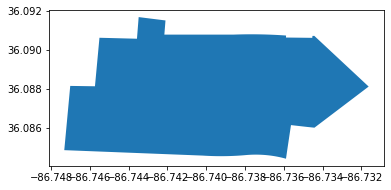

In [15]:
zoo.plot()

#### ...but what route does it use?

In [16]:
stops_and_parks.loc[stops_and_parks['name']== 'Grassmere / Nashville Zoo']

,stop,route,location,lat,lng,geometry,index_right,acres,name,park_type
330,NASHVILLE ZOO STATION OUTBOUND,NOLENSVILLE PK BRT LITE,"(36.089633, -86.733396)",36.089633,-86.733396,POINT (-86.73340 36.08963),77,196.59,Grassmere / Nashville Zoo,PARK


#### How many stops are there?

In [17]:
zoo_bus_route = bus_geodf.loc[bus_geodf['route'] == 'NOLENSVILLE PK BRT LITE']
zoo_bus_route.shape

(86, 6)

#### Let's plot the bus route with all the parks... 

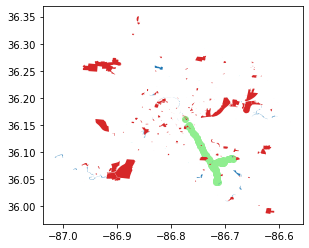

In [18]:
ax = zoo_bus_route.plot(color = 'lightgreen')
parks.plot(ax = ax, column = 'park_type')


#### hmmm, not great
#### maybe all the routes??

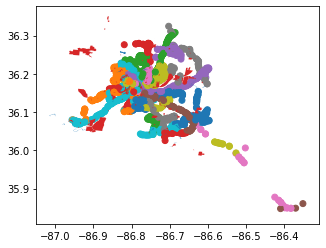

In [19]:
ax1 = bus_geodf.plot(column = 'route')
parks.plot(ax = ax1, column = 'park_type')


#### now that is poetry

In [20]:
fol_map = folium.Map(location = [36.15,-86.8])
fol_map

In [21]:
for row_index, row_values in zoo_bus_route.iterrows():
    print('index is', row_index)
    print('values are:')
    print(' ')
    print(row_values)
    print('-----')

index is 24
values are:
 
stop          HARDING PL & ANTIOCH PK EB
route            NOLENSVILLE PK BRT LITE
location         (36.087226, -86.692475)
lat                              36.0872
lng                             -86.6925
geometry    POINT (-86.692475 36.087226)
Name: 24, dtype: object
-----
index is 25
values are:
 
stop        NOLENSVILLE PIKE & FAIRLANE DR NB
route                 NOLENSVILLE PK BRT LITE
location              (36.064303, -86.717023)
lat                                   36.0643
lng                                   -86.717
geometry         POINT (-86.717023 36.064303)
Name: 25, dtype: object
-----
index is 27
values are:
 
stop        CONVENTION CENTER STATION INBOUND
route                 NOLENSVILLE PK BRT LITE
location               (36.160899, -86.77444)
lat                                   36.1609
lng                                  -86.7744
geometry          POINT (-86.77444 36.160899)
Name: 27, dtype: object
-----
index is 29
values are:
 
stop    

In [26]:
fol_map = folium.Map(location = [36.15,-86.8])

folium.GeoJson(zoo).add_to(fol_map)

folium.GeoJson(polygon37207).add_to(map_37207)

for row_index, row_values in zoo_bus_route.iterrows():
    loc = [row_values['lat'],row_values['lng']]
    pop = str(row_values['stop'])
    marker = folium.Marker(
        location = loc,
        popup = pop)
    
    marker.add_to(fol_map)
fol_map.save('../maps/buz_to_zoo.html')

fol_map

RuntimeError: b'no arguments in initialization list'

In [23]:
zoo_bus_route

,stop,route,location,lat,lng,geometry
24,HARDING PL & ANTIOCH PK EB,NOLENSVILLE PK BRT LITE,"(36.087226, -86.692475)",36.087226,-86.692475,POINT (-86.69248 36.08723)
25,NOLENSVILLE PIKE & FAIRLANE DR NB,NOLENSVILLE PK BRT LITE,"(36.064303, -86.717023)",36.064303,-86.717023,POINT (-86.71702 36.06430)
27,CONVENTION CENTER STATION INBOUND,NOLENSVILLE PK BRT LITE,"(36.160899, -86.77444)",36.160899,-86.774440,POINT (-86.77444 36.16090)
29,WOODYCREST STATION INBOUND,NOLENSVILLE PK BRT LITE,"(36.131406, -86.756197)",36.131406,-86.756197,POINT (-86.75620 36.13141)
37,JOYNER STATION OUTBOUND,NOLENSVILLE PK BRT LITE,"(36.116599, -86.74822)",36.116599,-86.748220,POINT (-86.74822 36.11660)
...,...,...,...,...,...,...
2341,LAFAYETTE STATION INBOUND,NOLENSVILLE PK BRT LITE,"(36.150359, -86.76764)",36.150359,-86.767640,POINT (-86.76764 36.15036)
2391,MORTON STATION OUTBOUND,NOLENSVILLE PK BRT LITE,"(36.106507, -86.743024)",36.106507,-86.743024,POINT (-86.74302 36.10651)
2434,ELYSIAN FIELDS STATION OUTBOUND,NOLENSVILLE PK BRT LITE,"(36.086226, -86.729653)",36.086226,-86.729653,POINT (-86.72965 36.08623)
2454,HARDING PL & TAMPA DR WB,NOLENSVILLE PK BRT LITE,"(36.08259, -86.711049)",36.082590,-86.711049,POINT (-86.71105 36.08259)


In [24]:
help(folium.Icon)

Help on class Icon in module folium.map:

class Icon(branca.element.MacroElement)
 |  Icon(color='blue', icon_color='white', icon='info-sign', angle=0, prefix='glyphicon', **kwargs)
 |  
 |  Creates an Icon object that will be rendered
 |  using Leaflet.awesome-markers.
 |  
 |  Parameters
 |  ----------
 |  color : str, default 'blue'
 |      The color of the marker. You can use:
 |  
 |          ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
 |           'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
 |           'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
 |           'gray', 'black', 'lightgray']
 |  
 |  icon_color : str, default 'white'
 |      The color of the drawing on the marker. You can use colors above,
 |      or an html color code.
 |  icon : str, default 'info-sign'
 |      The name of the marker sign.
 |      See Font-Awesome website to choose yours.
 |      Warning : depending on the icon you choose you may need to adapt
 |      the `